In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [5]:
ham10000_metadata = pd.read_csv("dataset/HAM10000_metadata.csv")

ham10000_metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [6]:
IMAGE_NAME = 1
ILLNESS = 2
DIAGNOSTIC = 3
AGE = 4
SEX = 5
LOCALIZATION = 6

In [7]:
ham10000_metadata = ham10000_metadata.dropna(how="any",axis=0) 


In [8]:
import os

from glob import glob

base_skin_dir = "dataset/HAM10000_images"

imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, "*.jpg"))
}

ham10000_metadata["path"] = ham10000_metadata["image_id"].map(imageid_path_dict.get)

In [9]:
lesion_type_dict = {
    "nv": "Melanocytic nevi",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesions",
    "bcc": "Basal cell carcinoma",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma"
}

ham10000_metadata["cell_type"] = ham10000_metadata["dx"].map(lesion_type_dict.get)
ham10000_metadata["cell_type_idx"] = pd.Categorical(ham10000_metadata["cell_type"]).codes

In [10]:
ham10000_metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,dataset/HAM10000_images/ISIC_0027850.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,dataset/HAM10000_images/ISIC_0029176.jpg,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,dataset/HAM10000_images/ISIC_0029068.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,dataset/HAM10000_images/ISIC_0025837.jpg,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,dataset/HAM10000_images/ISIC_0025209.jpg,Benign keratosis-like lesions,2


In [11]:
from PIL import Image


ham10000_metadata["image"] = ham10000_metadata["path"].map(lambda x: np.asarray(Image.open(x).resize((200,150))))

In [37]:
from sklearn.model_selection import train_test_split

x = ham10000_metadata.drop(columns=["cell_type_idx"],axis=1)
y = ham10000_metadata["cell_type_idx"]

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.20, random_state=123)

In [38]:
print("train shape:", x_train_o.shape)
print("test shape:", x_test_o.shape)

print("Distribuição de classes em train:", y_train_o.nunique())
print("Distribuição de classes em test:", y_test_o.nunique())

train shape: (7966, 10)
test shape: (1992, 10)
Distribuição de classes em train: 7
Distribuição de classes em test: 7


In [39]:
x_train = np.asarray(x_train_o["image"].tolist())
x_test = np.asarray(x_test_o["image"].tolist())

y_train = to_categorical(y_train_o, num_classes = y_train_o.nunique())
y_test = to_categorical(y_test_o, num_classes = y_test_o.nunique())

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

x_train = x_train.reshape(x_train.shape[0], *(150, 200, 3))
x_test = x_test.reshape(x_test.shape[0], *(150, 200, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(150, 200, 3))

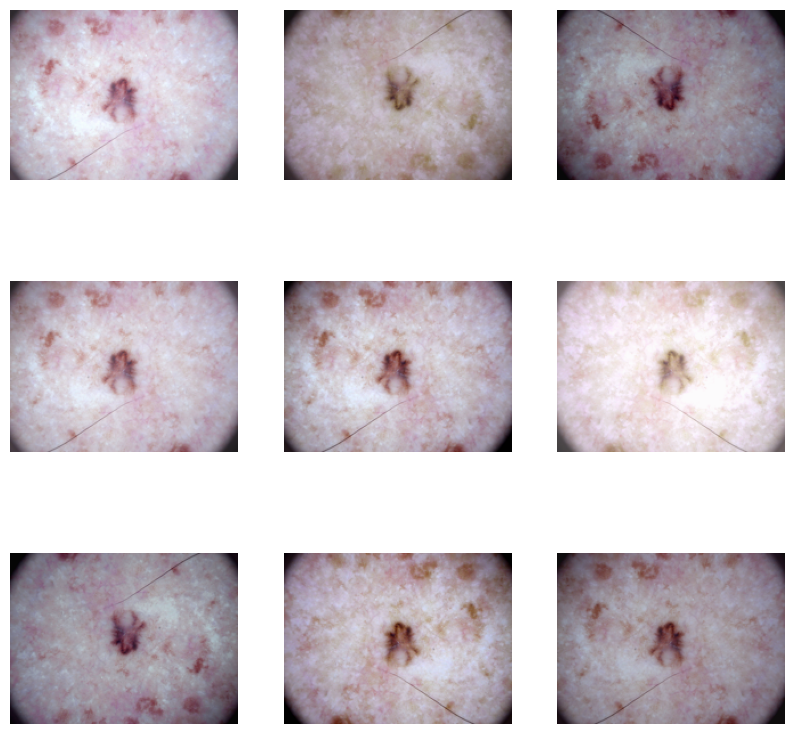

In [18]:
import tensorflow as tf

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

image = x_train[0]

plt.figure(figsize=(10, 10))

for i in range(9):
    augmented_image = augment_image(image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

plt.show()

In [40]:
x_train = x_train.reshape(x_train.shape[0], 150, 200, 3)
x_test = x_test.reshape(x_test.shape[0], 150, 200, 3)
x_validate = x_validate.reshape(x_validate.shape[0], 150, 200, 3)

In [41]:
len(x_train)

7169

In [42]:
x_augment = []
y_augment = []

for i in range(len(x_train)):
    x_augment.append(augment_image(x_train[i]))
    y_augment.append(y_train[i])

x_train = np.concatenate((x_train, x_augment))
y_train = np.concatenate((y_train, y_augment))

In [20]:
len(x_train)

14338

In [17]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(x_train)

train_dataset = datagen.flow(x_train, y_train)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, AveragePooling2D

def create_model():
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-3, name="adam")

    model = Sequential([
        # 1 Convolutional layer
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),

        # 2 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # 3 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),

        # 4 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # 5 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # 6 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),

        # 7 Convolutional layer
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="Same"),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        # 8 Denser layer
        Dense(128, activation="relu"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        # Output
        Dense(y_train_o.nunique(), activation="softmax")
    ])

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping_monitor = EarlyStopping(patience=100, monitor="val_accuracy")
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    patience=10,
    verbose=0,
    factor=0.1,
    mode="auto",
    min_lr=0.00001
)
model_checkpoint_callback = ModelCheckpoint(
    filepath="model.keras",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="auto",
    save_best_only=True,
    verbose=1
)

epochs = 100
batch_size = 64

model = create_model()

history = model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stopping_monitor, model_checkpoint_callback, learning_rate_reduction],
    validation_data=(x_validate, y_validate)
)

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

predictions = model.predict(x_test)

loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)

print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5584 - loss: 1.3682
Epoch 1: val_accuracy improved from -inf to 0.63739, saving model to model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - accuracy: 0.5586 - loss: 1.3677 - val_accuracy: 0.6374 - val_loss: 3.4065 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6842 - loss: 0.9471
Epoch 2: val_accuracy improved from 0.63739 to 0.66876, saving model to model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.6842 - loss: 0.9470 - val_accuracy: 0.6688 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6791 - loss: 0.9097
Epoch 3: val_accuracy did not improve from 0.66876
449/449 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.6791 - loss: 0.9096 - val_accuracy: 0.6349 - val_loss: 5.0187 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6962 - loss: 0.8817
Epoch 4: val_a

In [43]:
from keras import saving


loaded_model = saving.load_model("model.keras")

y_pred = loaded_model.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step


In [44]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [55]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

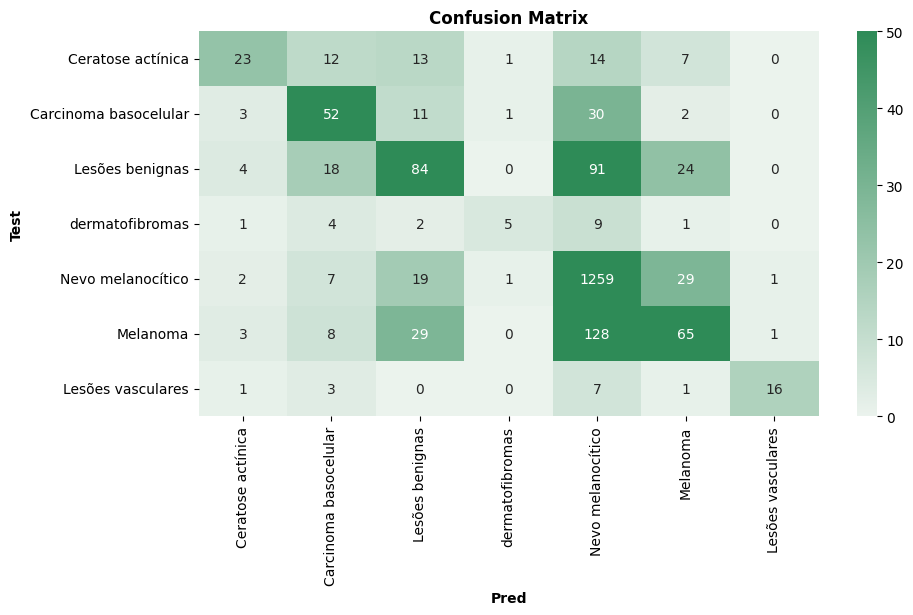

In [68]:
import seaborn as sn


categories = [
    "Ceratose actínica",
    "Carcinoma basocelular",
    "Lesões benignas", 
    "dermatofibromas", 
    "Nevo melanocítico",
    "Melanoma", 
    "Lesões vasculares"
]

CMatrix = pd.DataFrame(cm, columns=categories, index=categories)

plt.figure(figsize=(10, 5))

ax = sn.heatmap(CMatrix, annot=True, fmt="g", vmin=0, vmax=50, cmap=sn.light_palette("seagreen", as_cmap=True))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_xlabel("Pred", fontsize=10, weight="bold")
ax.set_ylabel("Test", fontsize=10, weight="bold")

ax.set_title("Confusion Matrix", fontsize=12, weight="bold")